In [1]:
#Control time packages
import time
import os
os.environ["OMP_NUM_THREADS"] = "1"

import autolens as al
import autolens.plot as aplt
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

from multiprocessing import Pool

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/SDP81/Autolens/ALMA/Data"

In [2]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)        #MGE decomposition

### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [3]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 3.042                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5
ml     = 7.00                                                          #mass to light ratio
phi_shear = 88                                                         #Inclination of external shear [deg]
mag_shear = 0.02                                                       #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

In [4]:
#Autolens Data
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/Alma_with_lens_center2.fits",
        noise_map_path=f"{data_folder}/rms_noise_map.fits",
        psf_path=f"{data_folder}/Alma_psf_rot.fits",
        pixel_scales=0.01,
        image_hdu=1, noise_map_hdu=1, psf_hdu=1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/mask2.fits", 
                                pixel_scales=imaging.pixel_scales)

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=False)   #Masked image
#aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

In [5]:
#--------------------------------------------------------------------------------------------------#
# PYAUTOLENS MODEL
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE()
ell_comps = al.convert.elliptical_comps_from(axis_ratio=0.85, phi=0.0) #Elliptical components in Pyautolens units
eNFW      = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s) #pseudo elliptical NFW


#Components

mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh)
mass_profile.Analytic_Model(analytic_profile=eNFW)



#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

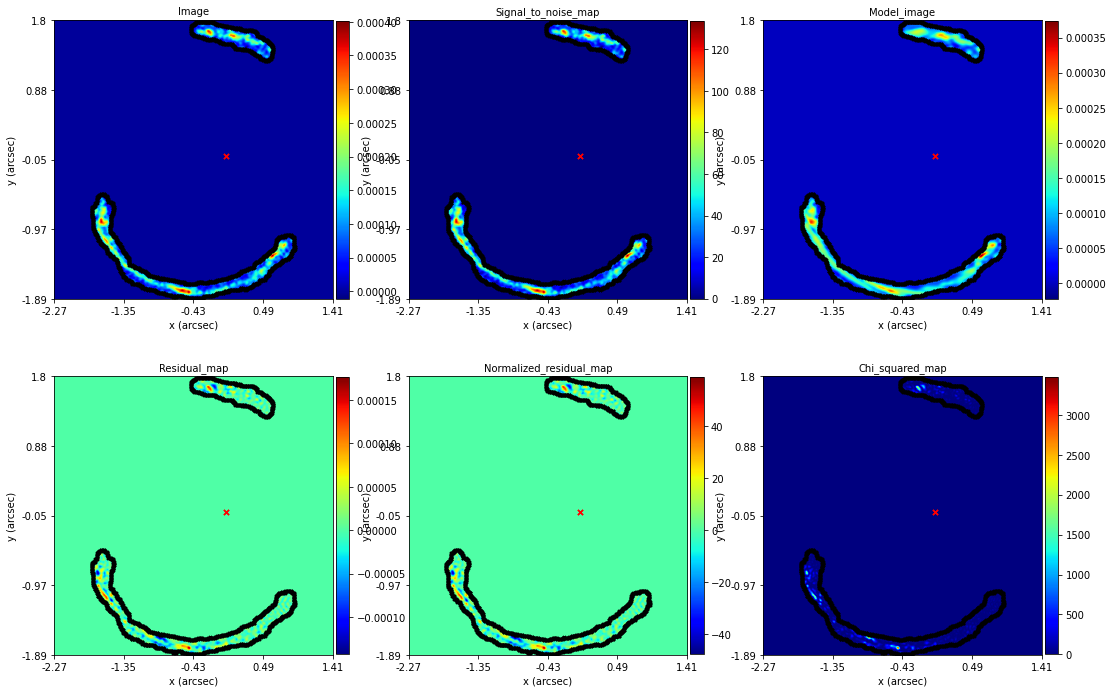

Log Likelihood with Regularization: -326645.0512968825
Log Evidence: -330613.8592386335
Log Likelihood : -326645.05094753124


In [6]:
source_galaxy = al.Galaxy(
    redshift=z_s,
    pixelization=al.pix.Rectangular(shape=(40, 40)),
    regularization=al.reg.Constant(coefficient=1.50),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True,critical_curves=False,caustics=False))
print("Log Likelihood with Regularization:", fit.log_likelihood_with_regularization)
print("Log Evidence:", fit.log_evidence)
print("Log Likelihood :", fit.log_likelihood)

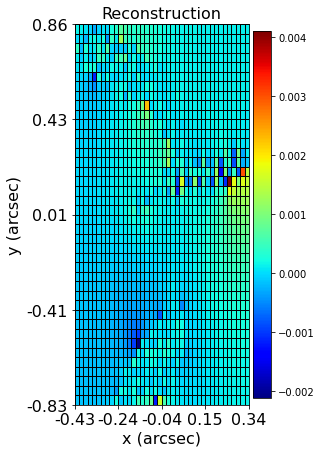

In [7]:
aplt.Inversion.reconstruction(fit.inversion, include=aplt.Include(inversion_grid=False, mask=False,
                                                                  border=False,inversion_border=False,
                                                                  inversion_pixelization_grid=False,
                                                                  inversion_image_pixelization_grid=False,))

In [8]:
boundary = {'ml': [0.5, 15], 'kappa_s': [0, 2], 'r_s': [5, 30], 'qDM': [0.1, 1], 'log_mbh':[7, 11],
                 'mag_shear': [0, 0.1], 'phi_shear': [0, 179], 'gamma': [0.95, 1.05]}


def prior_transform(theta):
    ml, kappa_s, qDM, r_s, log_mbh, mag_shear, phi_shear, gamma = theta
    parsDic = {"ml": ml, "kappa_s": kappa_s, "r_s": r_s, "qDM": qDM,
                    "log_mbh":log_mbh, "mag_shear": mag_shear, "phi_shear": phi_shear, 
                    "gamma": gamma}
    for key in parsDic:
        parsDic[key] = boundary[key][0] + parsDic[key]*(boundary[key][1] - boundary[key][0])
        
    return np.array(list(parsDic.values()))

def log_likelihood(pars):
    quiet=False
    ml_model, kappa_s_model, r_s_model, qDM_model, log_mbh_model, mag_shear_model, phi_shear_model, gamma_model = pars
    
    ell_comps = al.convert.elliptical_comps_from(axis_ratio=qDM_model, phi=0.0) #Elliptical components in Pyautolens units
    eNFW = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_s_model,elliptical_comps=ell_comps, scale_radius=r_s_model) #Set the analytical model
    mass_profile.Analytic_Model(eNFW)        #Include analytical model
    mass_profile.MGE_Updt_parameters(ml=ml_model, mbh=10**log_mbh_model, gamma=gamma_model)
    shear_comp_model = al.convert.shear_elliptical_comps_from(magnitude=mag_shear_model, phi=phi_shear_model)
    #New lens model
    lens_galaxy = al.Galaxy(                                            
            redshift=mass_profile.z_l,
            mass=mass_profile,
            shear=al.mp.ExternalShear(elliptical_comps=shear_comp_model),
        )

    source_galaxy = al.Galaxy(
            redshift=mass_profile.z_s,
            pixelization=al.pix.Rectangular(shape=(40, 40)),
            regularization=al.reg.Constant(coefficient=1.5),
        )
    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])
    
    try:
        fit = al.FitImaging(masked_imaging=masked_image, tracer=tracer)

        log_evidence = fit.log_evidence

            
        if quiet is False:
            print("Lens Galaxy Configuration:")
            print("Log Likelihood_with_regularization:", fit.log_likelihood)
            print("Log Normalization", fit.log_likelihood)
            print("Log Evidence:", fit.log_evidence)
            print("#------------------------------------#")
            print(lens_galaxy)
            print("\n")


            aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=False))
            aplt.Inversion.reconstruction(fit.inversion, include=aplt.Include(mask=False,
                                                                  border=False,inversion_border=False,
                                                                  inversion_pixelization_grid=False,
                                                                  inversion_grid=False,
                                                                  inversion_image_pixelization_grid=False,))              


        return log_evidence, fit
    except:
        print("An exception ocurres in Pyautolens_log_likelihood().")
        return -np.inf


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -326645.05094753124
Log Normalization -326645.05094753124
Log Evidence: -330613.8592386335
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.0
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108109)
axis_ratio: 0.8499999999999999
phi: 0.0
kappa_s: 0.075
scale_radius: 11.5
inner_slope: 1.0
z_l: 0.299
z_s: 3.042
critical_density: 2164845147317488.8
surf_lum: [1.79642955e+04 5.06247308e+03 7.28033611e+02 2.77239730e+02
 1.39133048e+02 9.16597040e+01 4.00566790e+01 2.95544940e+01
 1.75839440e+01]
sigma_lum: [0.04569  0.13247  0.263819 0.554257 0.691878 1.070566 1.479681 2.651813
 2.651813]
qobs_lum: [0.718002 0.616098 0.819906 1.       0.468808 1.       0.571622 0.612282
 1.      ]
ml: 7.0
surf_dm: None
sigma_dm: None
qobs_dm: None
mbh: 1000000000.0
sigma_mbh: 0.01
qobs_mbh: 1.0
D_l

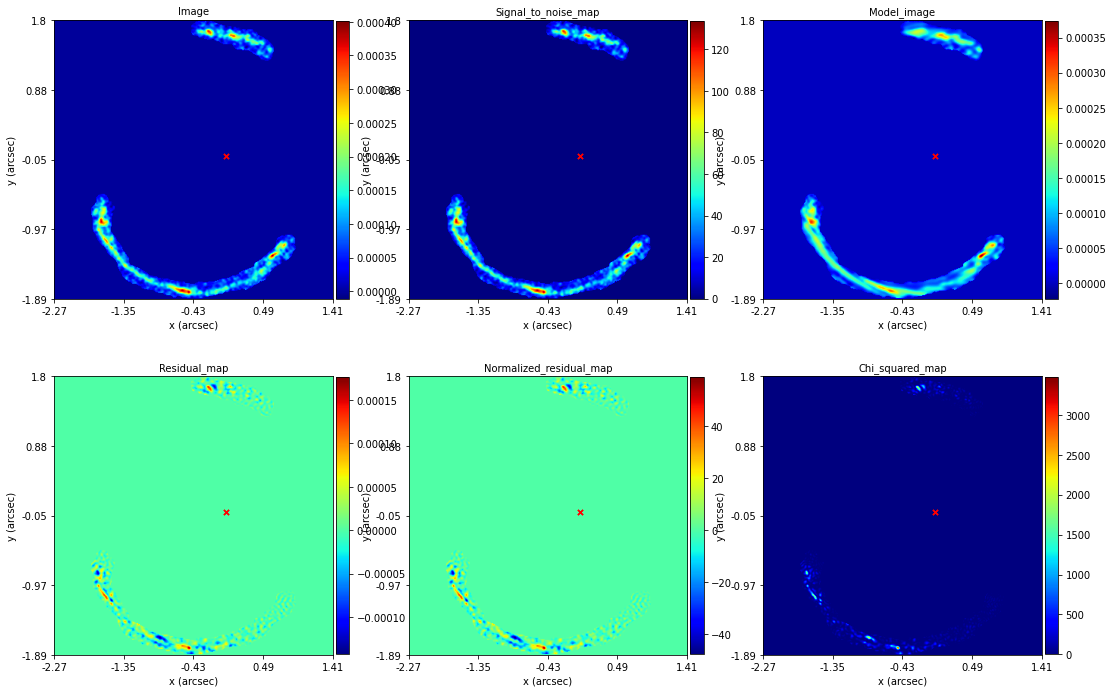

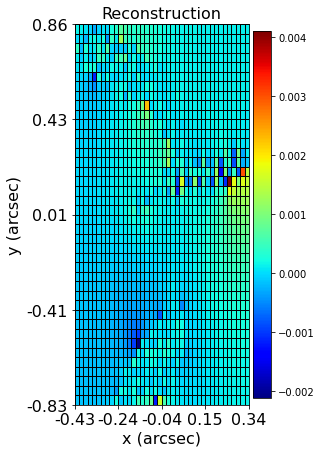

Array(-330613.85923863)

In [9]:
# ml, kappa_s, r_s qDM, log_mbh, mag_shear, phi_shear, gamma = pars
p0 = np.array([ml, kappa_, r_s, 0.85, np.log10(mbh), 0.02, 88., 1.0])
log_likelihood(p0)

In [9]:
from dynesty import NestedSampler

nlive = 100              # number of (initial) live points
ndim  = p0.size          #number of dimensions


# Now run with the static sampler
sampler = NestedSampler(log_likelihood, prior_transform, ndim, pool=Pool(),queue_size=6,
                        nlive=nlive)

In [9]:
import pickle 
import shutil

from dynesty import plotting as dyplot
from dynesty import utils as dyfunc


labels = ["ml", "kappa_s", "rs","qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]



original = r"dynesty_lens.pickle"
beckup   = r"beckup/dynesty_lens_beckup.pickle"

start = time.time()
for it, res in enumerate(sampler.sample()):
    if (it+1) % 100:
        continue
    
    print("Saving...")
    with open(f"dynesty_lens.pickle", "wb") as f:
                pickle.dump(sampler, f)
    print("File Save!")
    print(sampler.results.summary())
    print("Cumulative Time [s]:", (time.time() - start))
    print("#############################")
    print("\n")
    
    beckup = shutil.copyfile(original, beckup)
    
    


## Loading Run 1

In [10]:
import pickle
with open(f'dynesty_lens.pickle','rb') as f:
    sample_load = pickle.load(f)

In [11]:
sample_load.results["logz"].shape

(201,)

In [12]:
sample_load.results["logz"][-1] - sample_load.results["logz"][201-2]

2706.8975803813373

In [13]:
# Adding the final set of live points.
for it_final, res in enumerate(sample_load.add_live_points()):
    pass

In [14]:
sample_load.results["logz"].shape

(241,)

In [15]:
sample_load.results["logz"][-1] - sample_load.results["logz"][241-2]

13191.975695003464

In [16]:
sample_load.results.summary()

Summary
nlive: 40
niter: 201
ncall: 3170
eff(%):  7.603
logz: -4914.276 +/-  0.691


In [17]:
result = sample_load.results

In [18]:
res[-1]

1.0986122886679368

In [19]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
dyplot.runplot(result)

#rfig.savefig("save.png")

LinAlgError: singular matrix

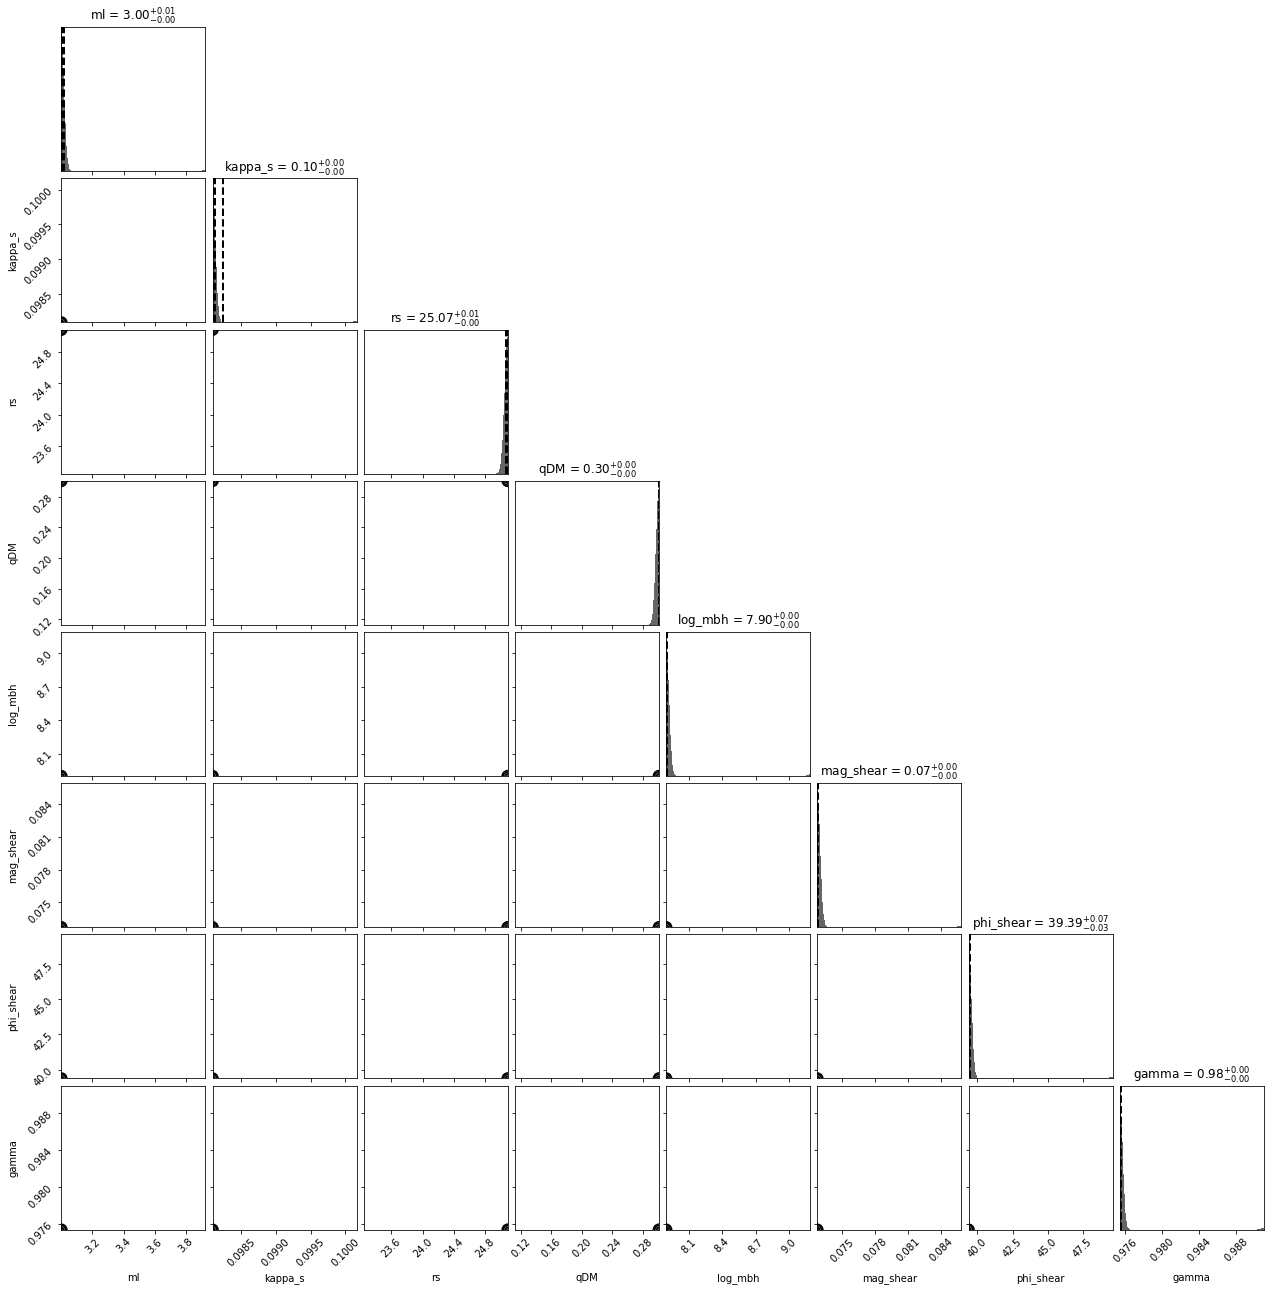

In [20]:
# Plot the 2-D marginalized posteriors.
labels = ["ml", "kappa_s", "rs","qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]
cfig, caxes = dyplot.cornerplot(result, show_titles=True,labels=labels,
                               )

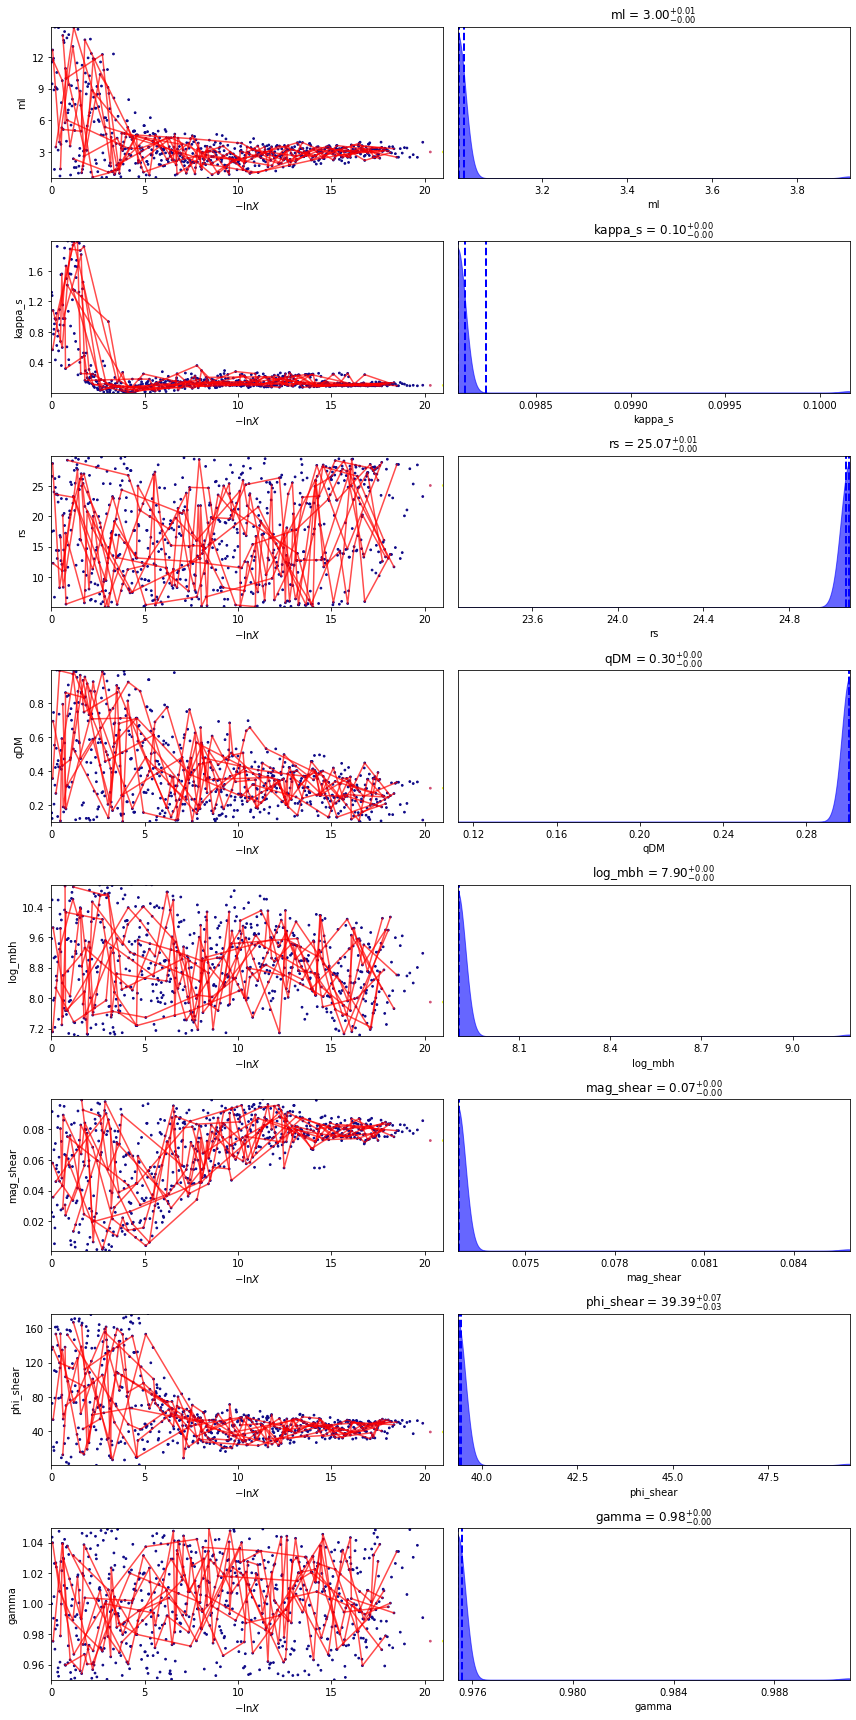

In [21]:
rfig, raxes = dyplot.traceplot(result, labels=labels, 
                                show_titles=True, connect=True)
plt.tight_layout()

In [22]:
from dynesty import utils as dyfunc

samples, weights = result.samples, np.exp(result.logwt - result.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)


In [23]:
mean

array([ 3.011893  ,  0.09811181, 25.04506956,  0.29800621,  7.91403262,
        0.07288733, 39.49208211,  0.97560772])

In [24]:
cov

array([[ 2.32008840e-02,  5.16872053e-05, -4.57674303e-02,
        -4.73485638e-03,  3.22481615e-02,  3.27412284e-04,
         2.55209151e-01,  3.87328057e-04],
       [ 5.16872053e-05,  1.15149371e-07, -1.01961225e-04,
        -1.05483693e-05,  7.18428377e-05,  7.29412979e-07,
         5.68557981e-04,  8.62894051e-07],
       [-4.57674303e-02, -1.01961225e-04,  9.02835286e-02,
         9.34025657e-03, -6.36146227e-02, -6.45872755e-04,
        -5.03440602e-01, -7.64066137e-04],
       [-4.73485638e-03, -1.05483693e-05,  9.34025657e-03,
         9.66293566e-04, -6.58123256e-03, -6.68185807e-05,
        -5.20833032e-02, -7.90462432e-05],
       [ 3.22481615e-02,  7.18428377e-05, -6.36146227e-02,
        -6.58123256e-03,  4.48234611e-02,  4.55088013e-04,
         3.54728980e-01,  5.38368181e-04],
       [ 3.27412284e-04,  7.29412979e-07, -6.45872755e-04,
        -6.68185807e-05,  4.55088013e-04,  4.62046202e-06,
         3.60152703e-03,  5.46599705e-06],
       [ 2.55209151e-01,  5.685579

Text(0, 0.5, '$- \\Delta \\ln X$')

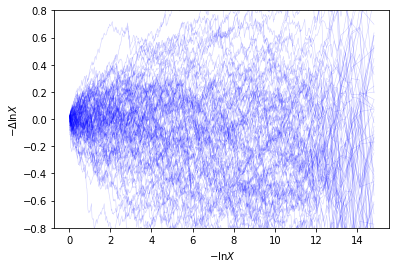

In [26]:
from dynesty import utils as dyfunc

# plot ln(prior volume) changes
for i in range(100):
    dres_j = dyfunc.jitter_run(result)
    plt.plot(-result.logvol, -result.logvol + dres_j.logvol, color='blue',
             lw=0.5, alpha=0.2)
plt.ylim([-0.8, 0.8])
plt.xlabel(r'$-\ln X$')
plt.ylabel(r'$- \Delta \ln X$')

In [23]:
# Extract sampling results.
samples = result.samples  # samples
weights = np.exp(result.logwt - result.logz[-1])  # normalized weights

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)



In [20]:

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(result)


samples_sim = results_sim.samples
weights = np.exp(results_sim.logwt - results_sim.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples_sim, weights)
mean

array([ 2.94219988,  0.15599486, 10.04303907,  0.31117593,  7.88516263,
        0.06492217, 47.77252659,  0.96255105])

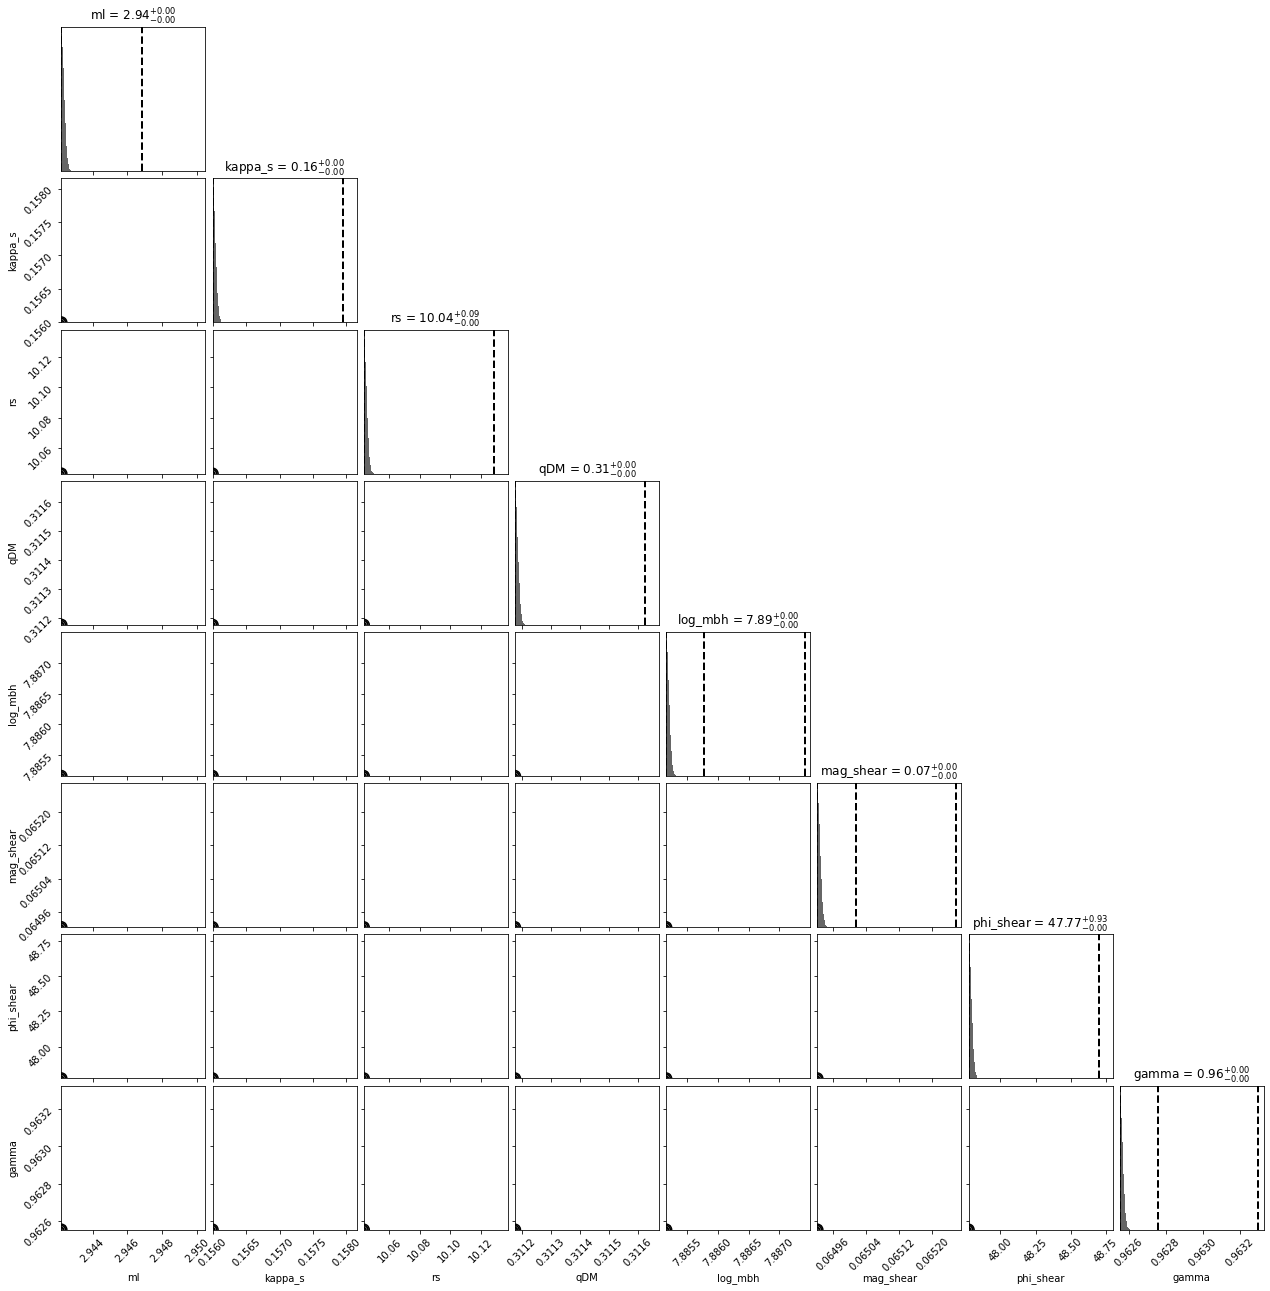

In [21]:
# Plot the 2-D marginalized posteriors.
labels = ["ml", "kappa_s", "rs", "qDM",
                    "log_mbh", "mag_shear", "phi_shear", 
                    "gamma"]
cfig, caxes = dyplot.cornerplot(results_sim, show_titles=True,labels=labels,
                               )

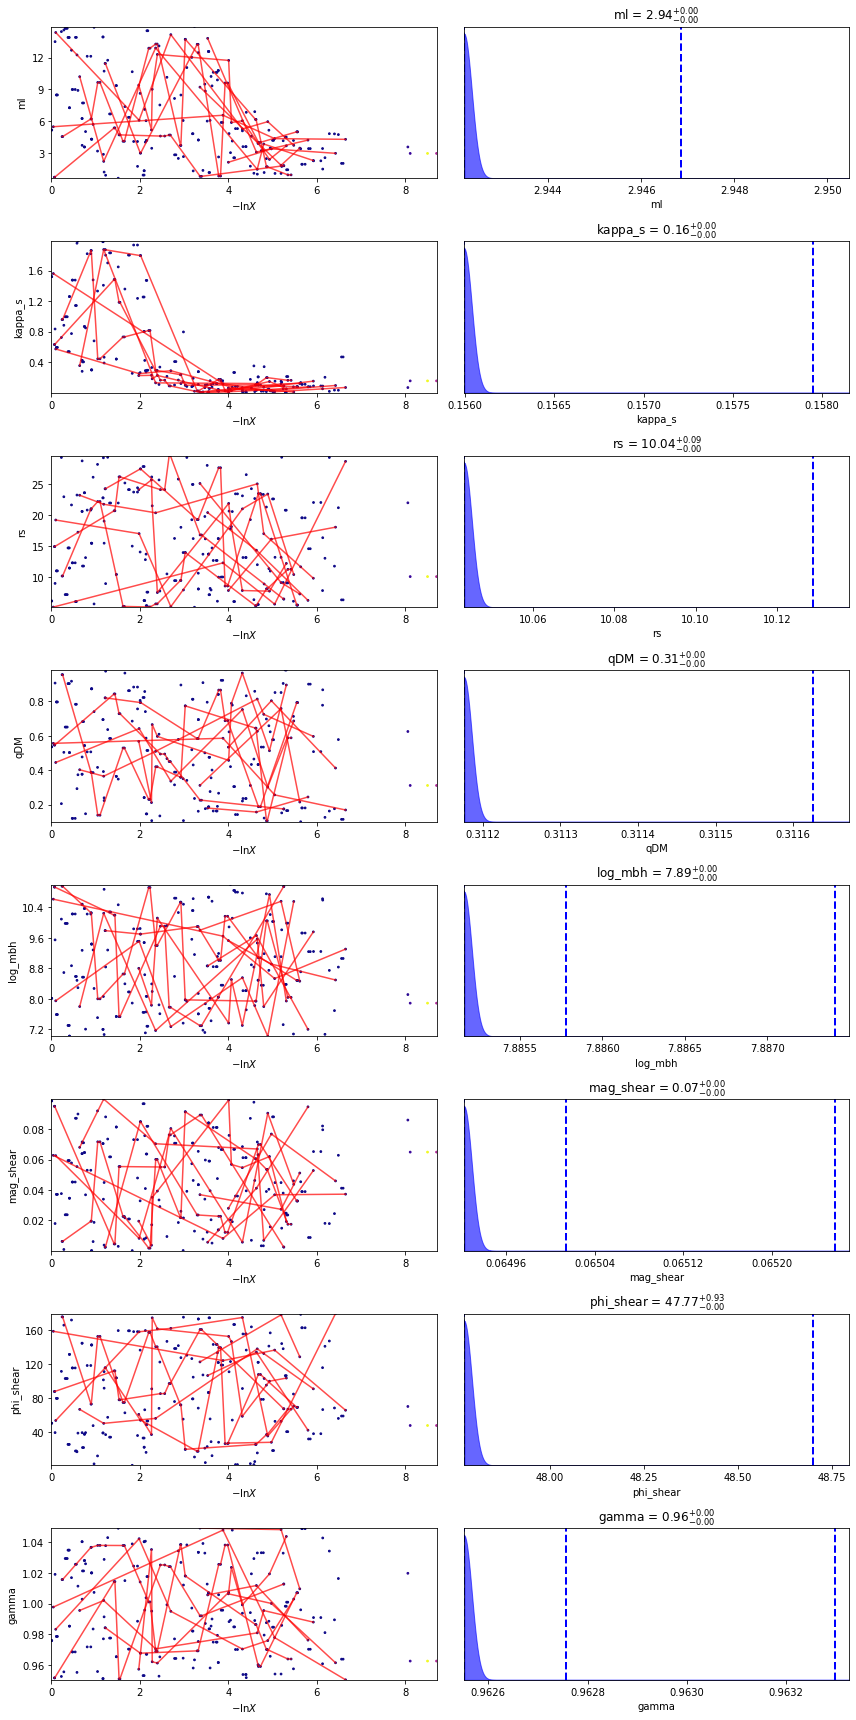

In [22]:
rfig, raxes = dyplot.traceplot(results_sim, labels=labels, 
                               show_titles=True, connect=True)
plt.tight_layout()

Lens Galaxy Configuration:
Log Likelihood_with_regularization: 20879.480697769643
Log Normalization 20879.480697769643
Log Evidence: 11528.785139841857
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 0.9625510489438144
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.5253483201941265)
axis_ratio: 0.31117592848921616
phi: 0.0
kappa_s: 0.1559948649548593
scale_radius: 10.043039069174906
inner_slope: 1.0
z_l: 0.299
z_s: 3.042
critical_density: 2164845147317488.8
surf_lum: [1.79642955e+04 5.06247308e+03 7.28033611e+02 2.77239730e+02
 1.39133048e+02 9.16597040e+01 4.00566790e+01 2.95544940e+01
 1.75839440e+01]
sigma_lum: [0.04569  0.13247  0.263819 0.554257 0.691878 1.070566 1.479681 2.651813
 2.651813]
qobs_lum: [0.718002 0.616098 0.819906 1.       0.468808 1.       0.571622 0.612282
 1.      ]
ml: 2.9421998827099443
surf_dm: None
sigma_dm: None
qobs_dm: N

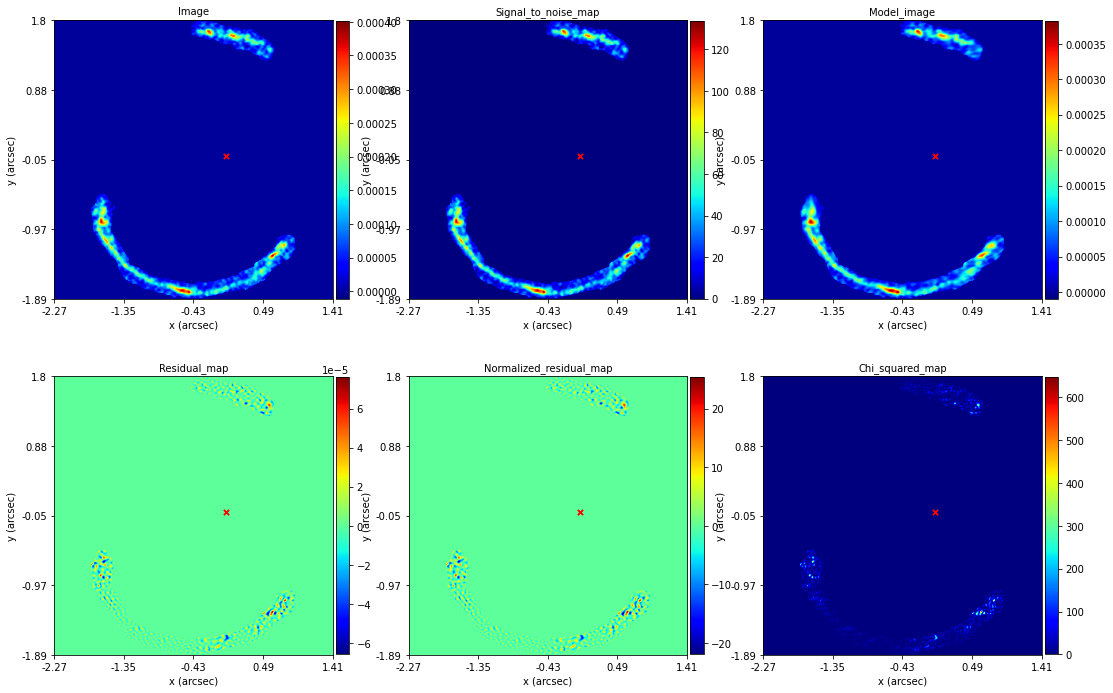

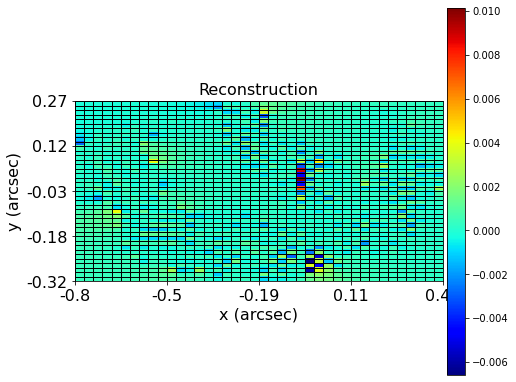

<Figure size 432x288 with 0 Axes>

In [23]:
log_evi, fit_fun = log_likelihood(mean)
plt.tight_layout()

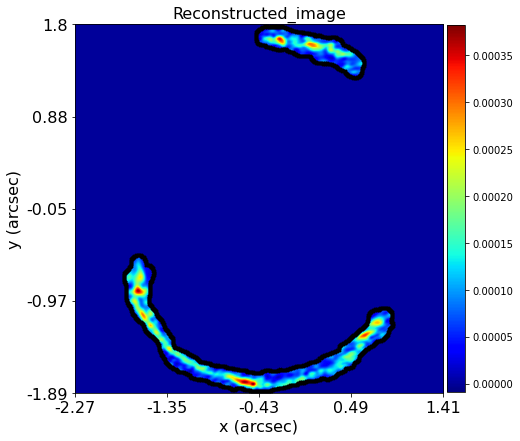

In [24]:
aplt.Inversion.reconstructed_image(fit_fun.inversion)

In [25]:
source = fit_fun.inversion.reconstruction
model = fit_fun.inversion.image

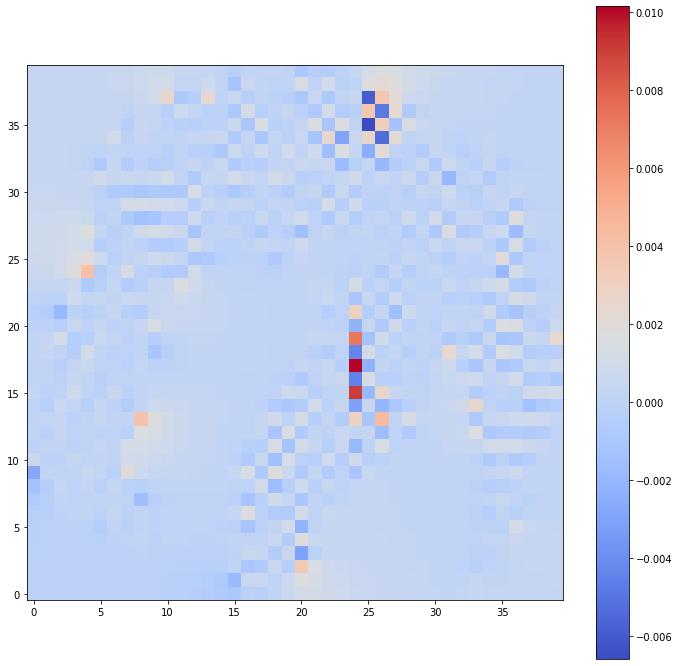

In [26]:
plt.figure(figsize=(12,12))
plt.imshow(source.reshape(40,40), cmap='coolwarm',origin='lower')
plt.colorbar()

In [27]:
from mpdaf.obj import Image

In [28]:
img = Image(data=source.reshape(40,40))

In [72]:
img.write("source.fits")

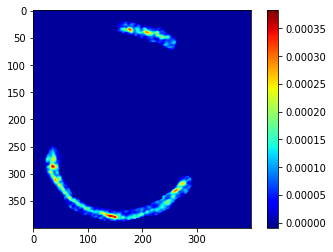

In [29]:
plt.imshow(fit_fun.model_data.in_2d, cmap="jet")
plt.colorbar()

In [109]:
model = fit_fun.model_data.in_2d
model_fits = Image(data=model,)
model_fits.write("model.fits")

In [112]:
residual = fit_fun.residual_map.in_2d
residual_fits = Image(data=residual)
residual_fits.write("residual.fits")